In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Euro to USD exchange Rate

In [2]:
data = pd.read_csv('./data/EUR_USD.csv', index_col='Time', parse_dates=['Time'])

In [3]:
def plot_raw_series(series, title, filename=None):
    plt.figure(figsize=(24, 10))
    plt.plot(series)
    plt.title(title)
    plt.grid(True)
    if filename is not None:
        plt.savefig(filename)

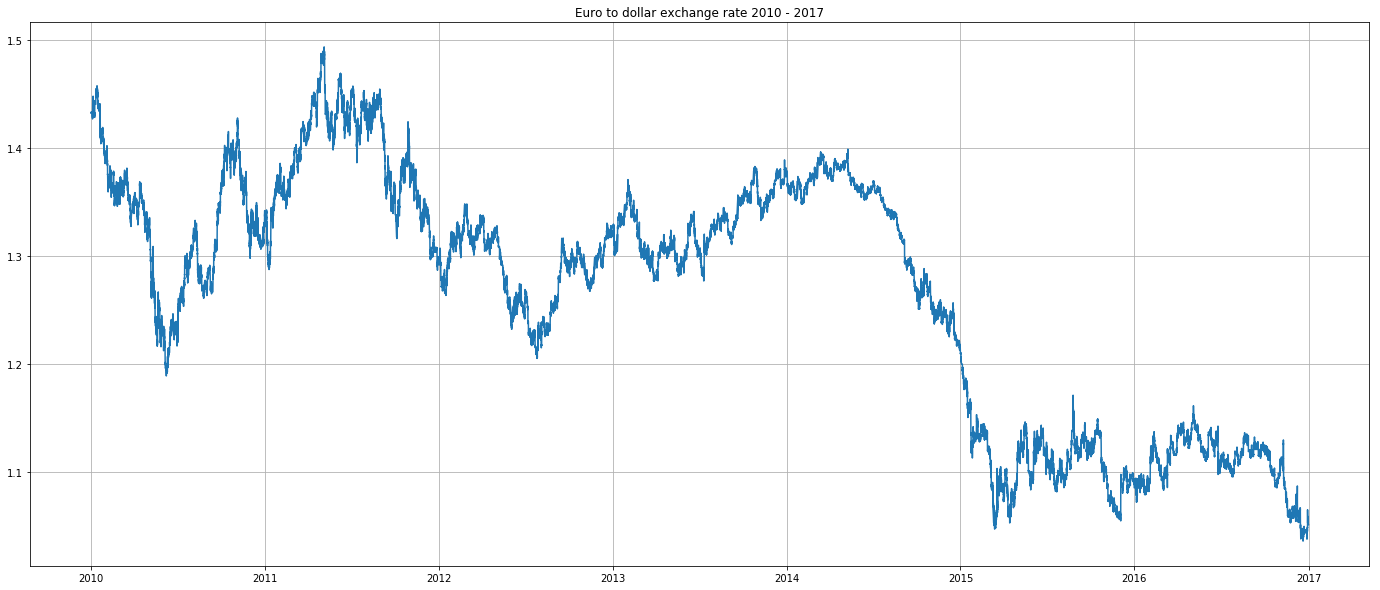

In [4]:
plot_raw_series(data, 'Euro to dollar exchange rate 2010 - 2017', 'charts/EUR_USD_raw.png')

In [11]:
def timeseries_train_test_split(X, y, test_count):
    """
        Perform train-test split with respect to time series structure
    """
    
    X_train = X.iloc[:-test_count]
    y_train = y.iloc[:-test_count]
    X_test = X.iloc[-test_count:]
    y_test = y.iloc[-test_count:]
    
    return X_train, X_test, y_train, y_test


def prepare_data(series, lag_start, lag_end, test_count):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_count: int
            size of the test dataset after train/test split
    """
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_count)

    return X_train, X_test, y_train, y_test


def predict_up_to_given_back(series, observations_back, observations_to_predict):
    """
        Predicts observations basing on past observations
    """
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test =\
        prepare_data(series, lag_start=1, lag_end=int(observations_back) + 1, test_count=int(observations_to_predict))

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    regressor = xgb.XGBRegressor() # gamma=0.0, n_estimators=150, base_score=0.7, colsample_bytree=1, learning_rate=0.01
    regressor.fit(X_train_scaled, y_train)
    y_predicted = regressor.predict(X_test_scaled)
    
    y_predicted_series = pd.Series(y_predicted, index=y_test.index)
    
    tscv = TimeSeriesSplit(n_splits=5)
    crossval_score = cross_val_score(regressor, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error")
    
    return y_predicted_series, y_test, crossval_score


def plot_results(y_predicted, y_actual, crossval_score, plt_intervals=False, plt_anomalies=False):
    plt.figure(figsize=(24, 10))
    plt.plot(y_predicted, "g", label="prediction", linewidth=2.0)
    plt.plot(y_actual, label="actual", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
    if plt_intervals:
        mae = crossval_score.mean() * (-1)
        deviation = crossval_score.std()
        
        scale = 1.96
        lower = y_predicted - (mae + scale * deviation)
        upper = y_predicted + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plt_anomalies:
            anomalies = np.array([np.NaN]*len(y_actual))
            anomalies[y_actual < lower] = y_actual[y_actual < lower]
            anomalies[y_actual > upper] = y_actual[y_actual > upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def process_data(
    series,
    observations_back,
    observations_to_predict,
    plt_draw=False,
    plt_title=None,
    plt_filename=None,
    plt_intervals=False,
    plt_anomalies=False,
):
    print(observations_back, observations_to_predict)
    y_predicted, y_actual, crossval_score = predict_up_to_given_back(series,
                                                                     observations_back,
                                                                     observations_to_predict)
    error = mean_absolute_percentage_error(y_actual.values, y_predicted.values)
    
    if (plt_draw and plt_title is not None):
        plot_results(
            y_predicted,
            y_actual,
            crossval_score,
            plt_intervals=plt_intervals,
            plt_anomalies=plt_anomalies
        )
        plt.title('{s} : mean absolute percentage error {e:.2f}'.format(s=plt_title, e=error))
        if plt_filename is not None:
            plt.savefig(plt_filename)

    return error
    

In [12]:
dataCountInDayEURUSD = 96
def daysEURUSD(count):
    return count * dataCountInDayEURUSD

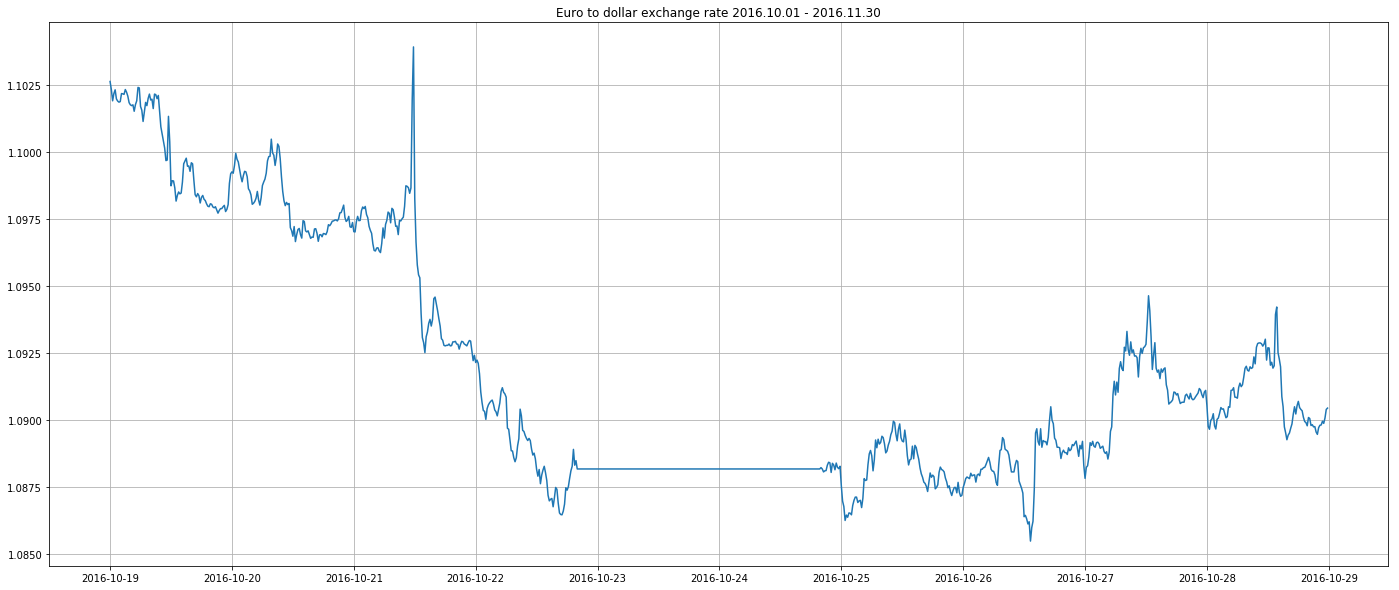

In [17]:
plot_raw_series(data['2016-10-19':'2016-10-28'], 'Euro to dollar exchange rate 2016.10.01 - 2016.11.30', 'charts/EUR_USD_raw_16_10_16_11.png')

96 192


0.048726285466065875

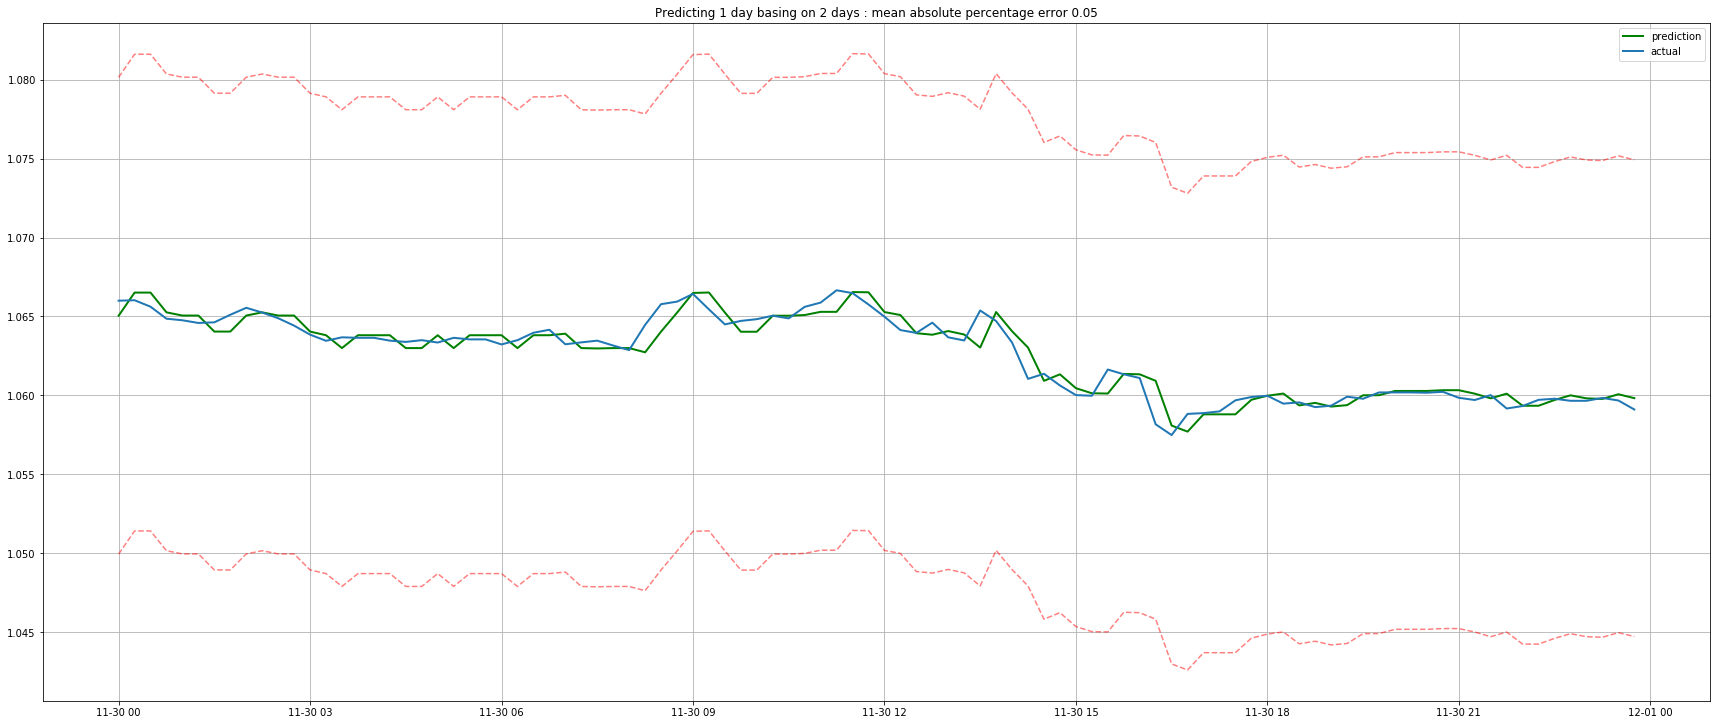

In [295]:
process_data(
    data['2016-10-01':'2016-10-28'],
    daysEURUSD(1),
    daysEURUSD(2),
    plt_draw=True,
    plt_title='Predicting 1 day basing on 2 days',
    plt_filename='charts/eur_usd_2d_1d.png',
    plt_intervals=True,
    plt_anomalies=True,
)

In [18]:
runs = [
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1) / 4, daysEURUSD(1) / 4, 'Predicting 6 hours basing on 6 hours', 'charts/eur_usd_6h_6h.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1) / 4, daysEURUSD(1) / 2, 'Predicting 12 hours basing on 6 hours', 'charts/eur_usd_6h_12h.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1) / 4, daysEURUSD(1), 'Predicting 1 day basing on 6 hours', 'charts/eur_usd_6h_1d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1) / 4, daysEURUSD(2), 'Predicting 2 days basing on 6 hours', 'charts/eur_usd_6h_2d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1) / 4, daysEURUSD(7), 'Predicting 7 days basing on 6 hours', 'charts/eur_usd_6h_7d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1) / 4, daysEURUSD(12), 'Predicting 12 days basing on 6 hours', 'charts/eur_usd_6h_12d.png'),

    (data['2016-10-01':'2016-11-30'], daysEURUSD(1), daysEURUSD(1) / 4, 'Predicting 6 hours basing on 1 day', 'charts/eur_usd_1d_6h.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1), daysEURUSD(1), 'Predicting 1 day basing on 1 day', 'charts/eur_usd_1d_1d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1), daysEURUSD(7), 'Predicting 7 days basing on 1 day', 'charts/eur_usd_1d_7d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(1), daysEURUSD(12), 'Predicting 12 days basing on 1 day', 'charts/eur_usd_1d_12d.png'),
    
    (data['2016-10-01':'2016-11-30'], daysEURUSD(7), daysEURUSD(1) / 4, 'Predicting 6 hours basing on 7 days', 'charts/eur_usd_7d_6h.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(7), daysEURUSD(1), 'Predicting 1 day basing on 7 days', 'charts/eur_usd_7d_1d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(7), daysEURUSD(7), 'Predicting 7 days basing on 7 days', 'charts/eur_usd_7d_7d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(7), daysEURUSD(12), 'Predicting 12 days basing on 7 days', 'charts/eur_usd_7d_12d.png'),
    
    (data['2016-10-01':'2016-11-30'], daysEURUSD(12), daysEURUSD(1) / 4, 'Predicting 6 hours basing on 12 days', 'charts/eur_usd_12d_6h.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(12), daysEURUSD(1), 'Predicting 1 day basing on 12 days', 'charts/eur_usd_12d_1d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(12), daysEURUSD(7), 'Predicting 7 days basing on 12 days', 'charts/eur_usd_12d_7d.png'),
    (data['2016-10-01':'2016-11-30'], daysEURUSD(12), daysEURUSD(12), 'Predicting 12 days basing on 12 days', 'charts/eur_usd_12d_12d.png'),
]

24.0 24.0
24.0 48.0
24.0 96
24.0 192
24.0 672
24.0 1152
96 24.0
96 96
96 672
96 1152
672 24.0
672 96
672 672
672 1152
1152 24.0
1152 96
1152 672
1152 1152


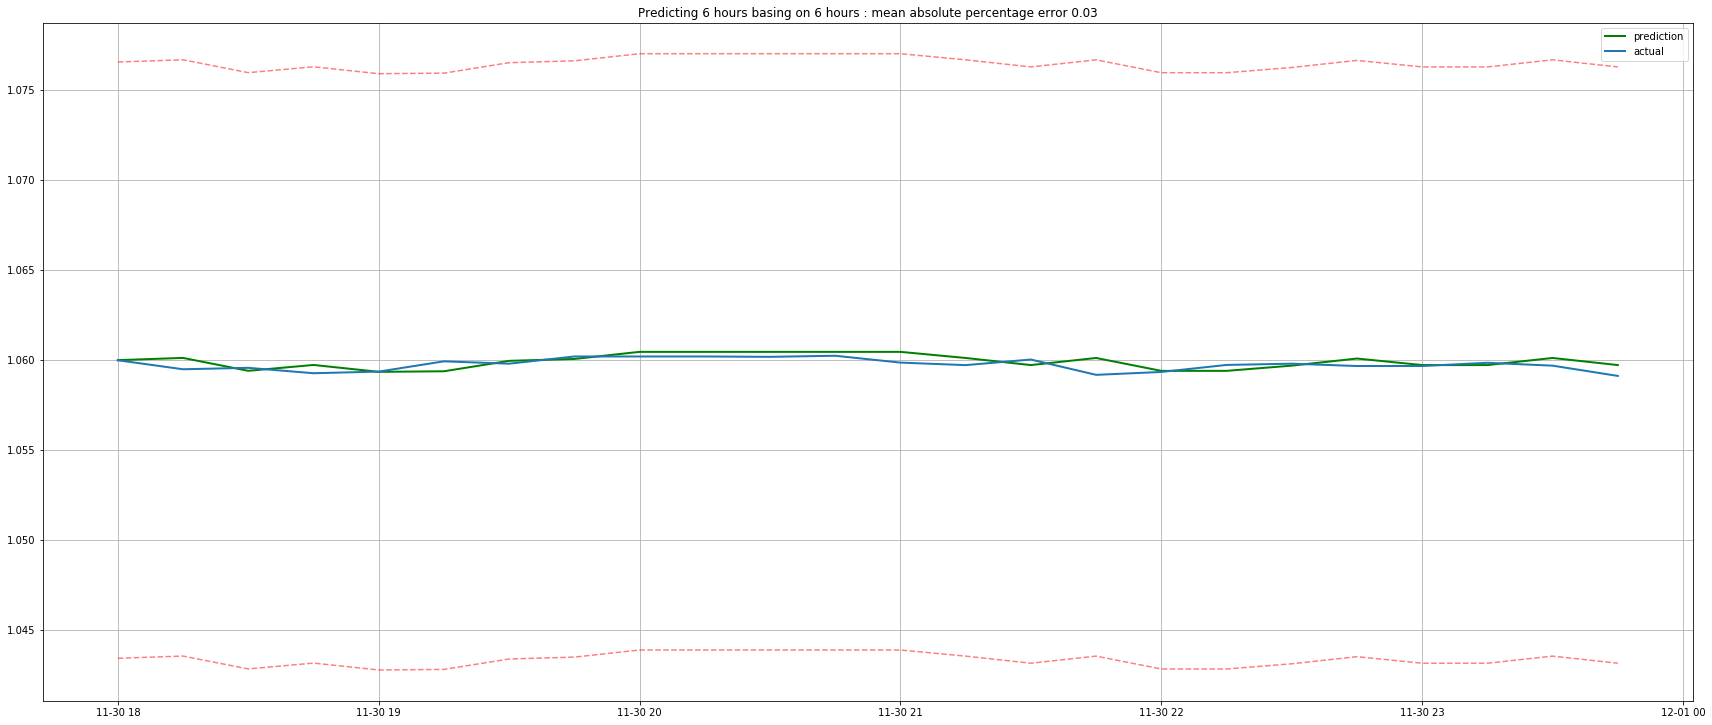

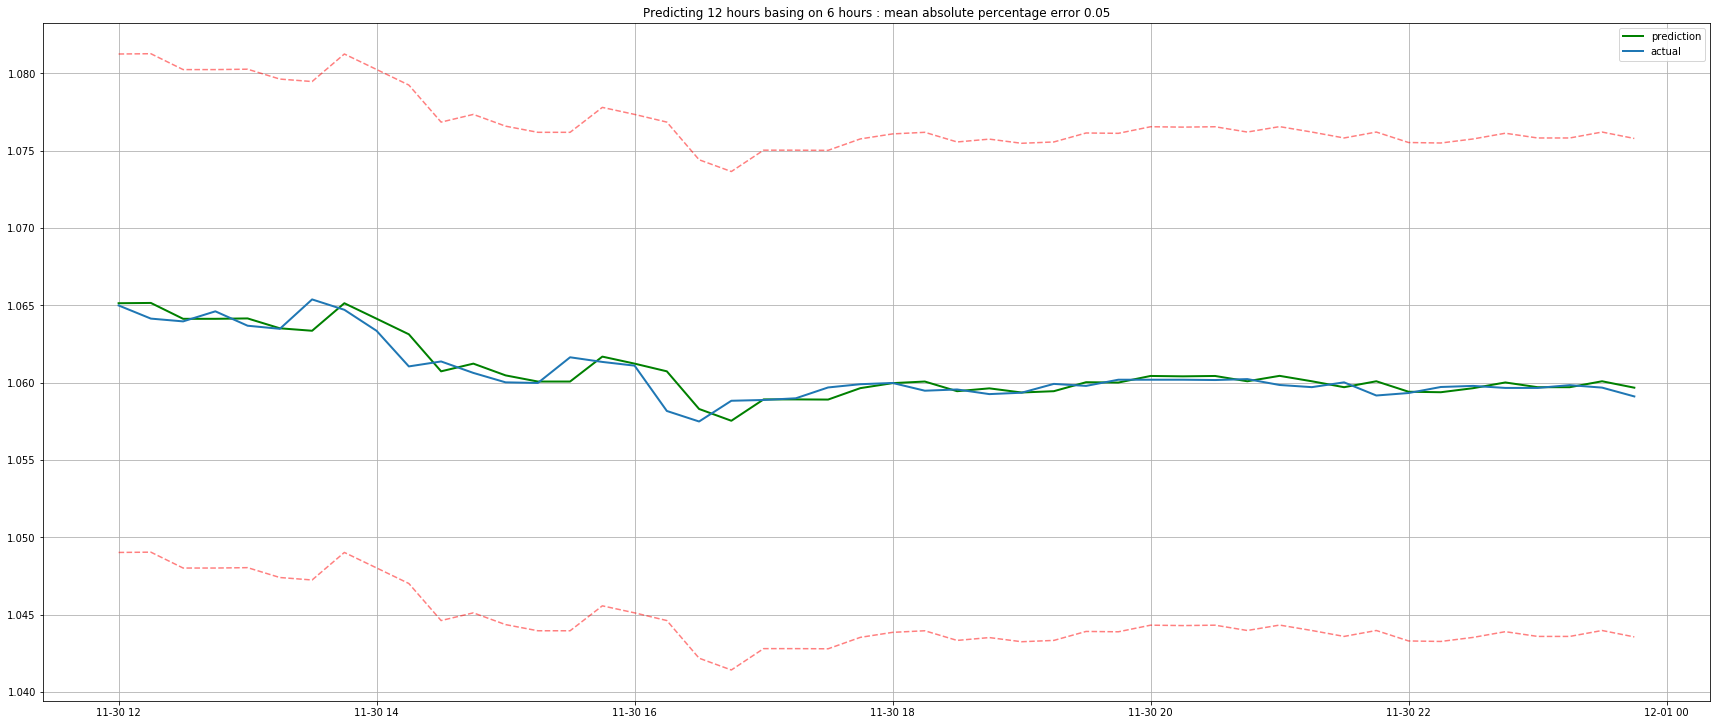

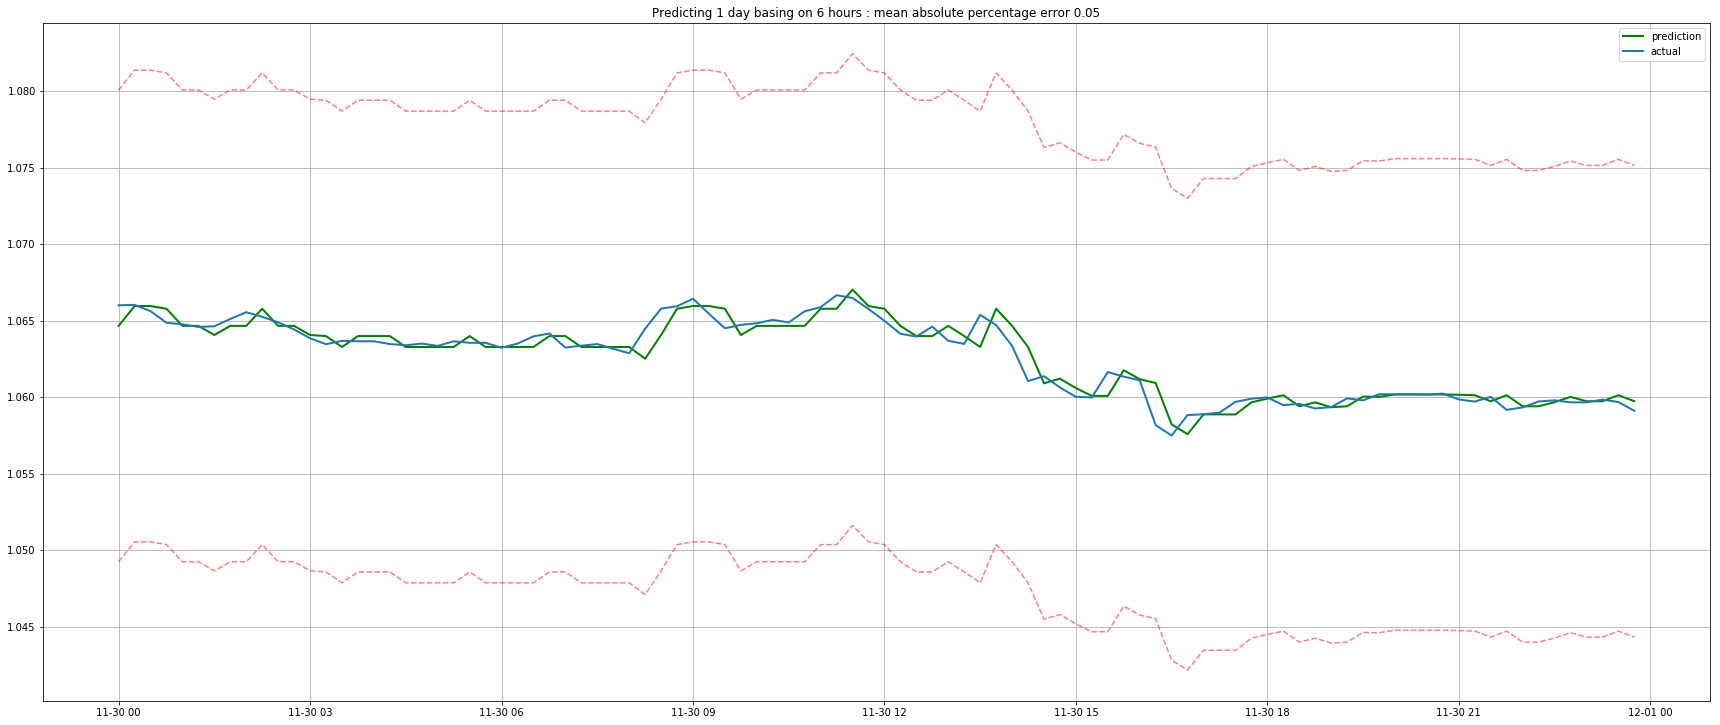

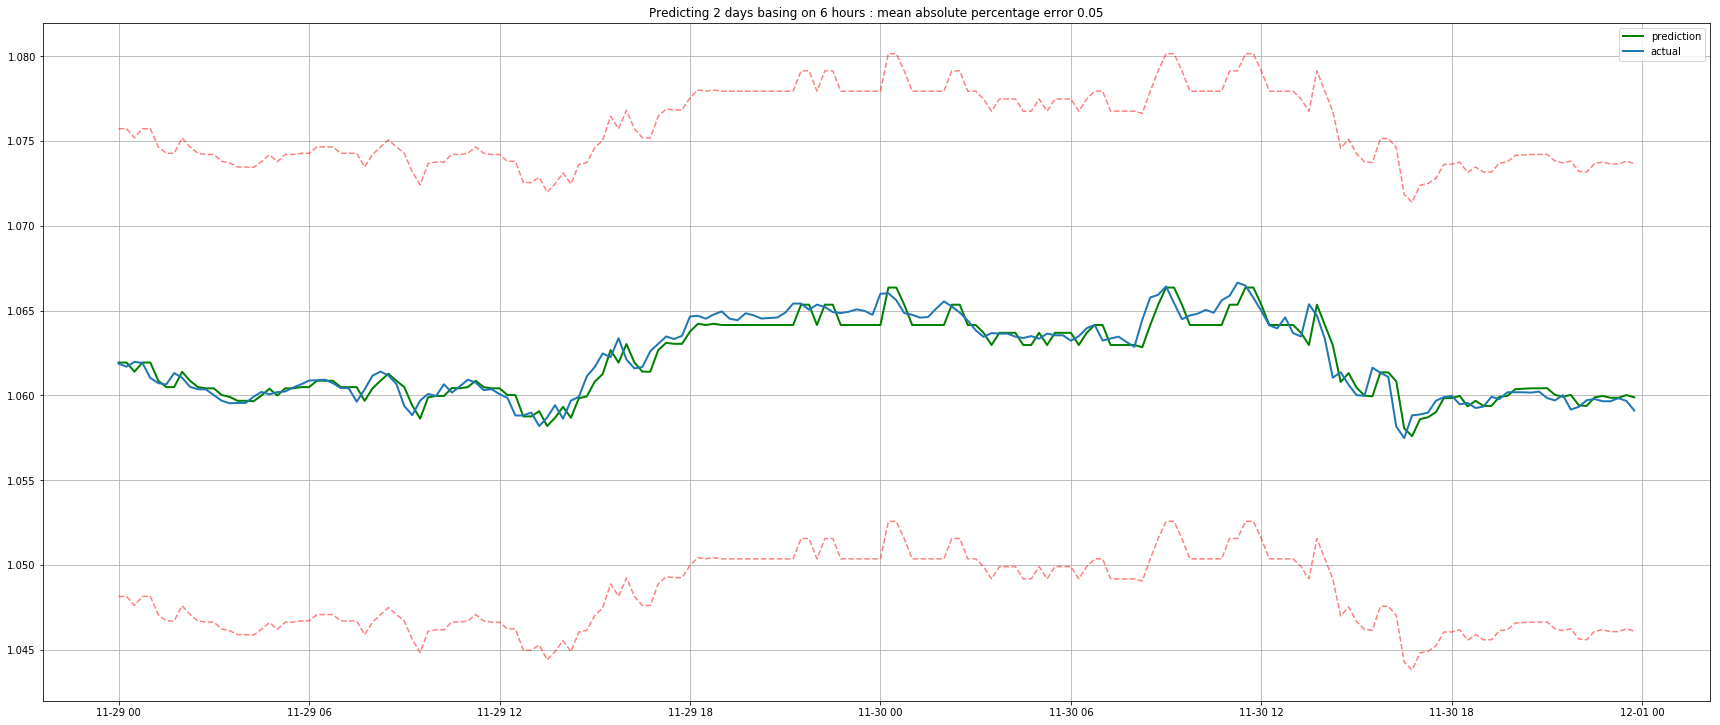

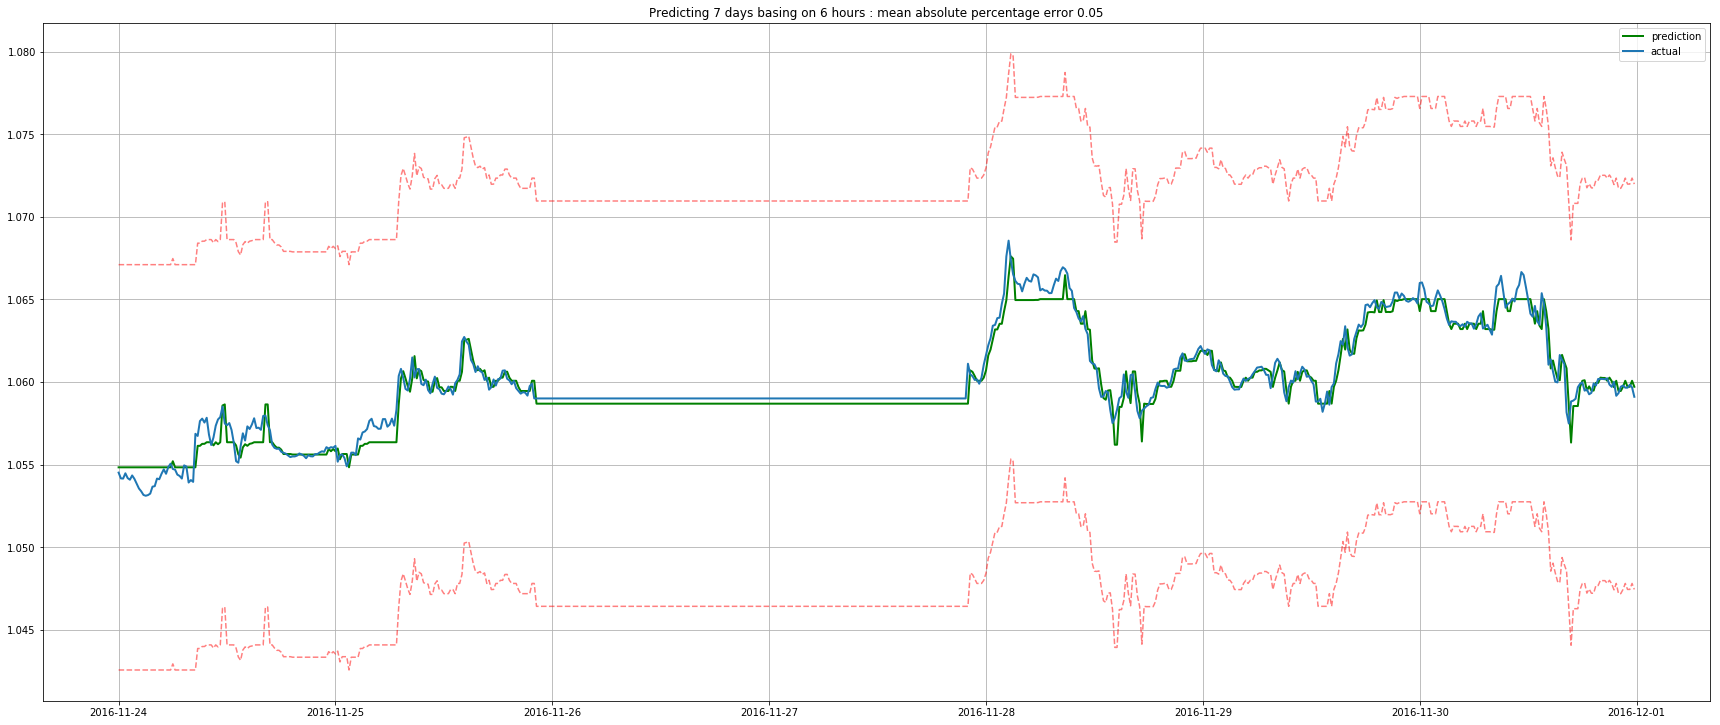

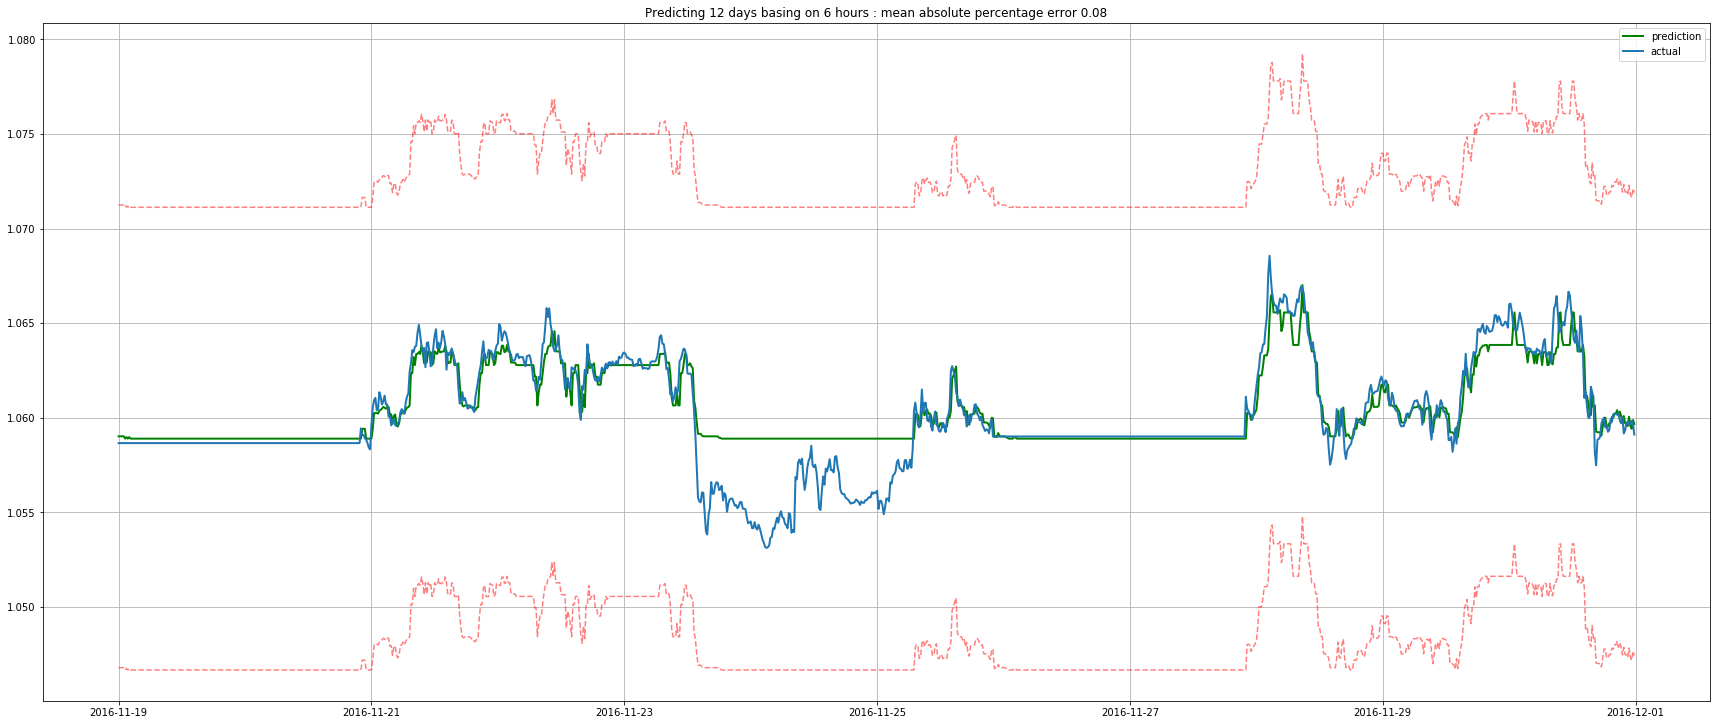

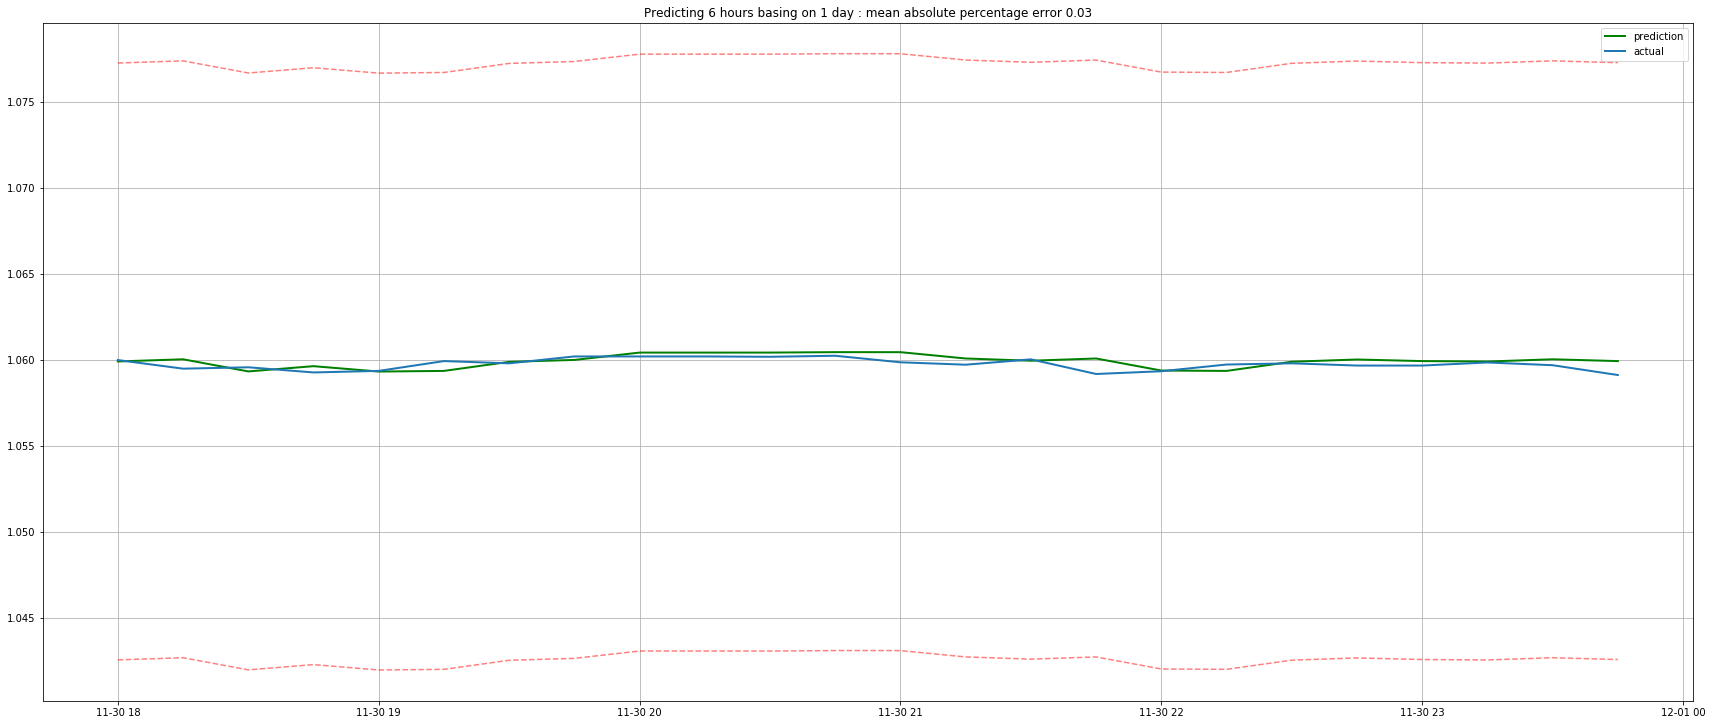

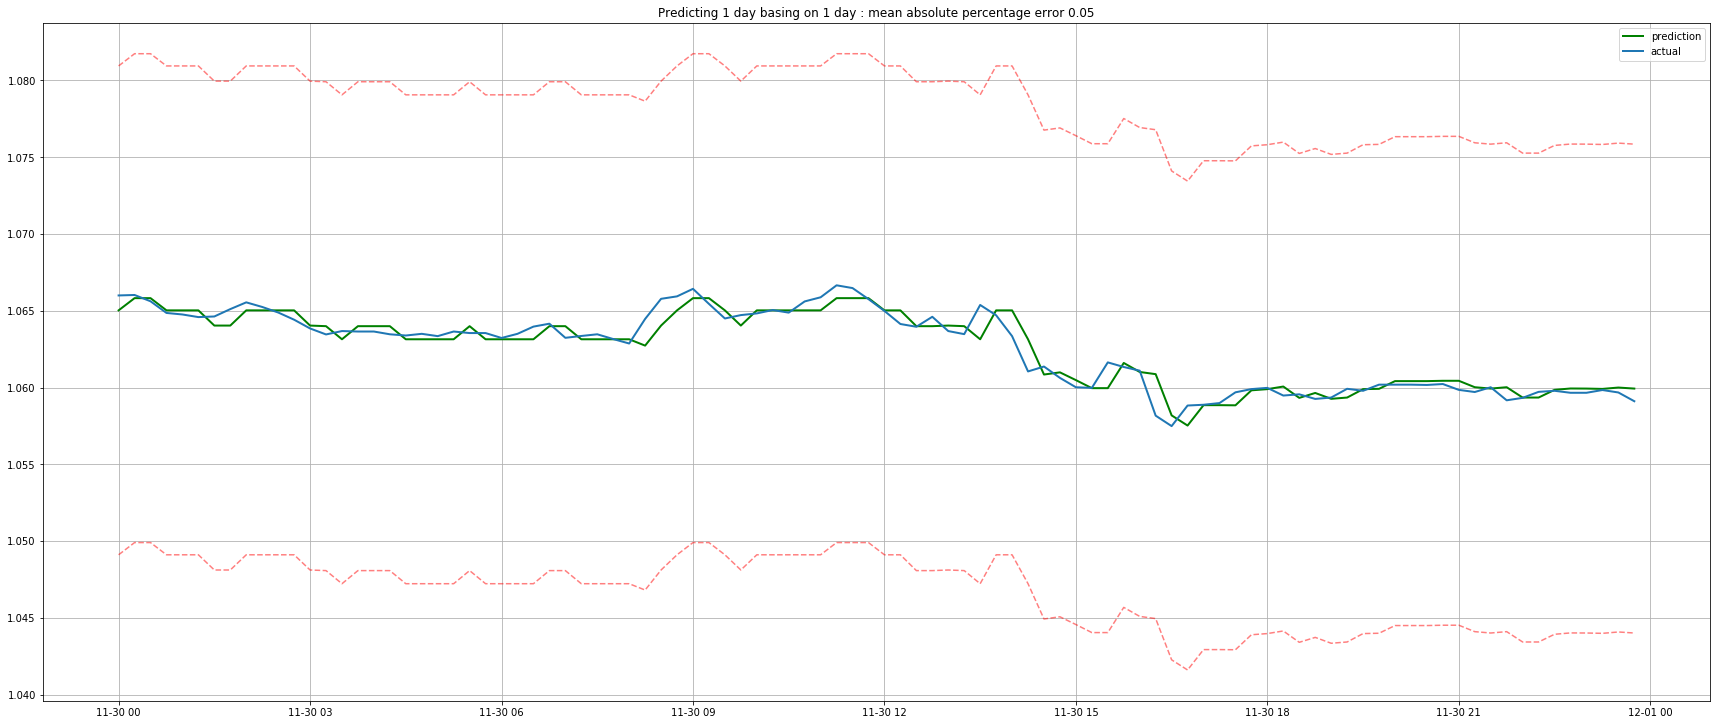

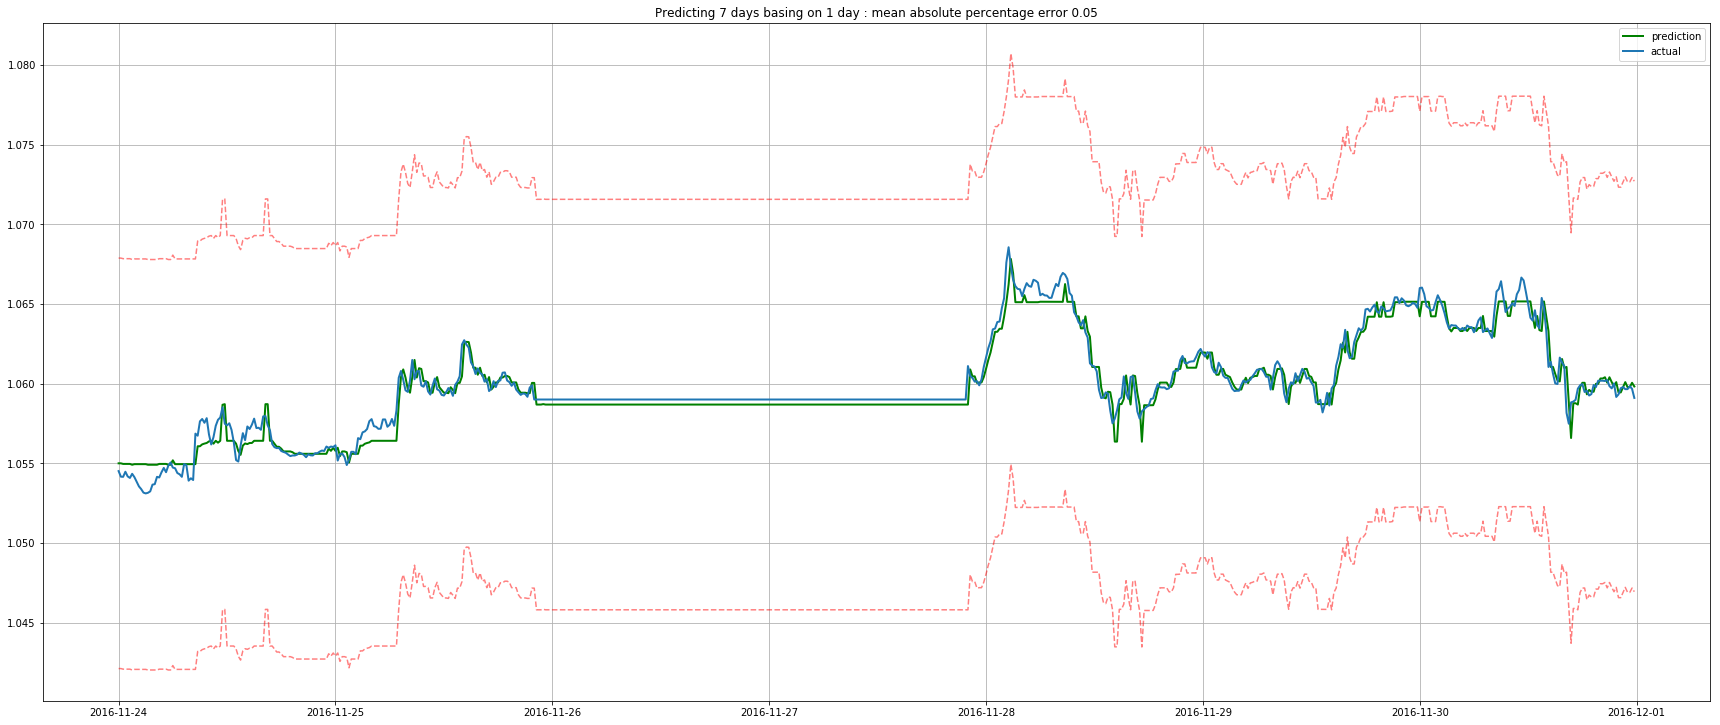

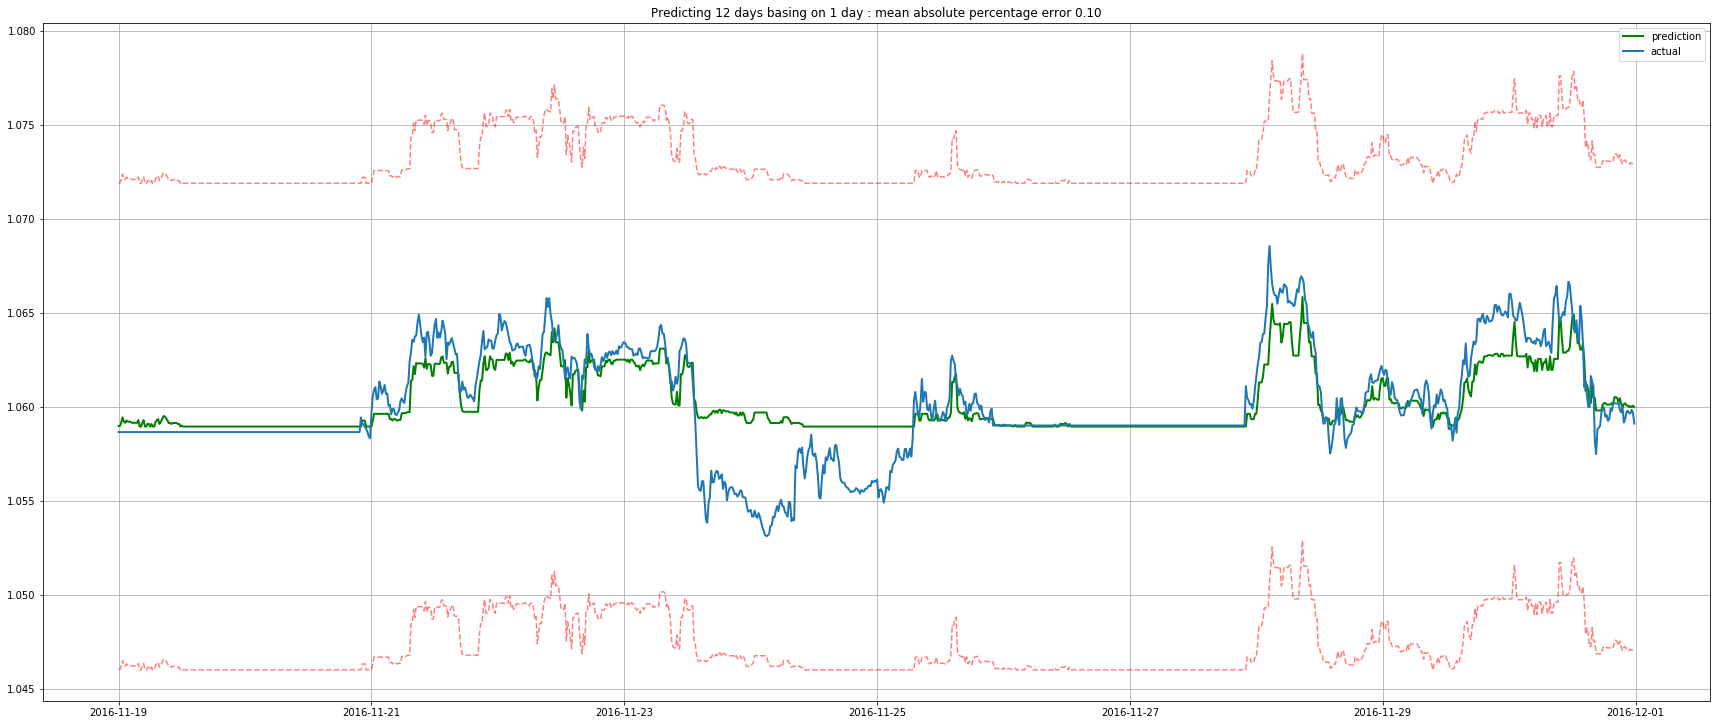

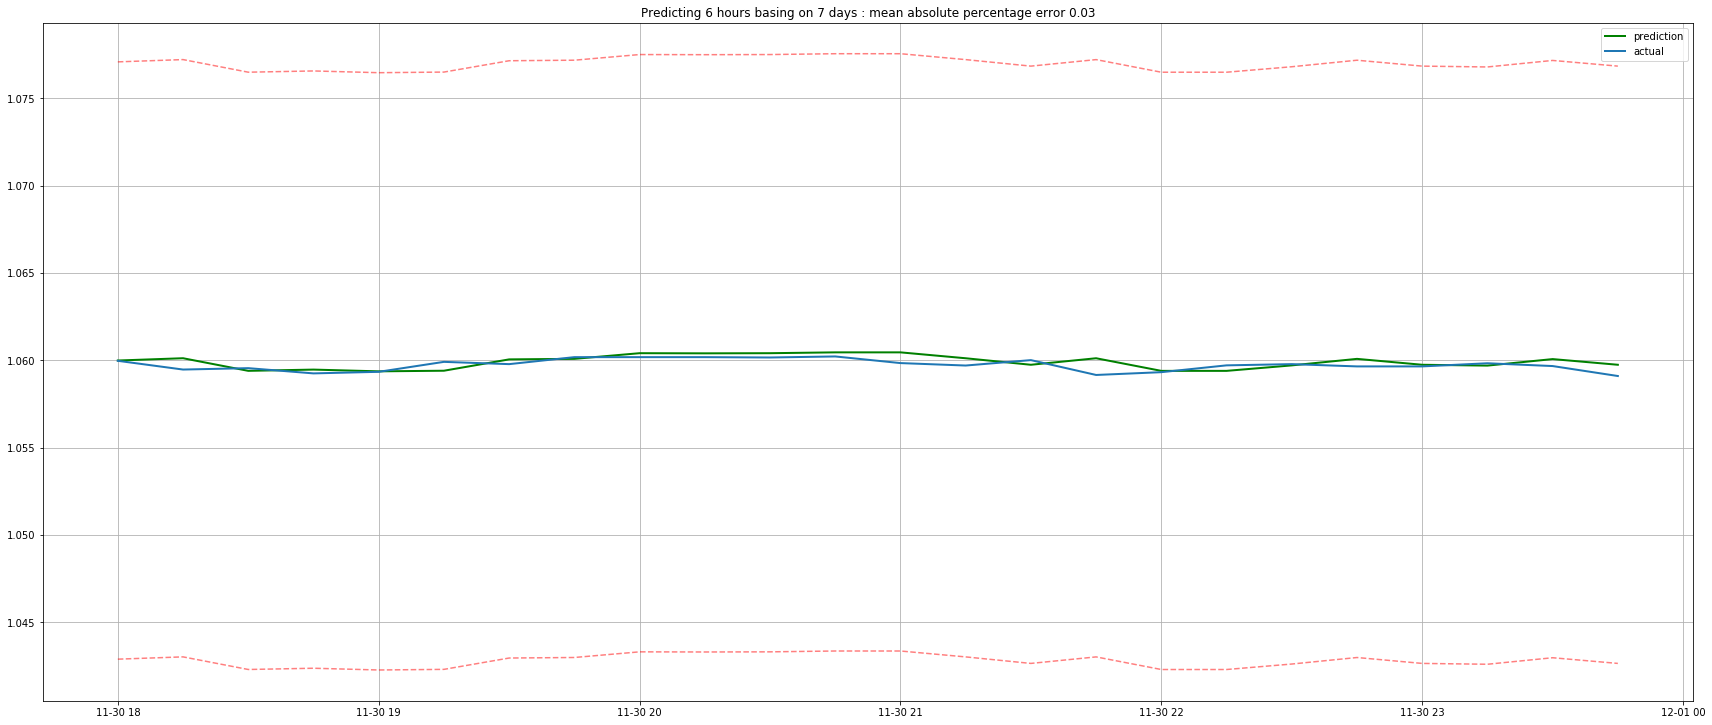

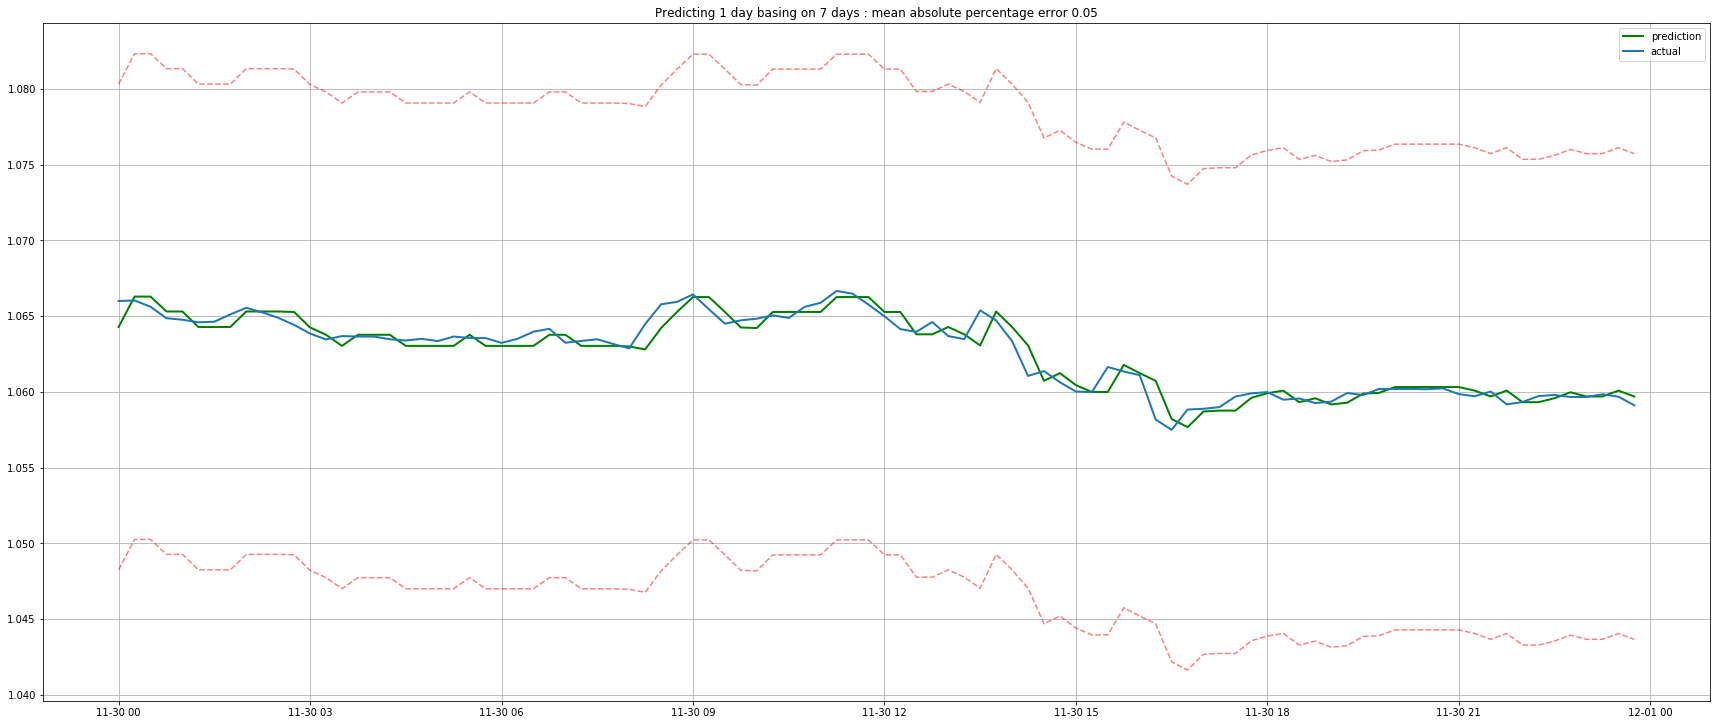

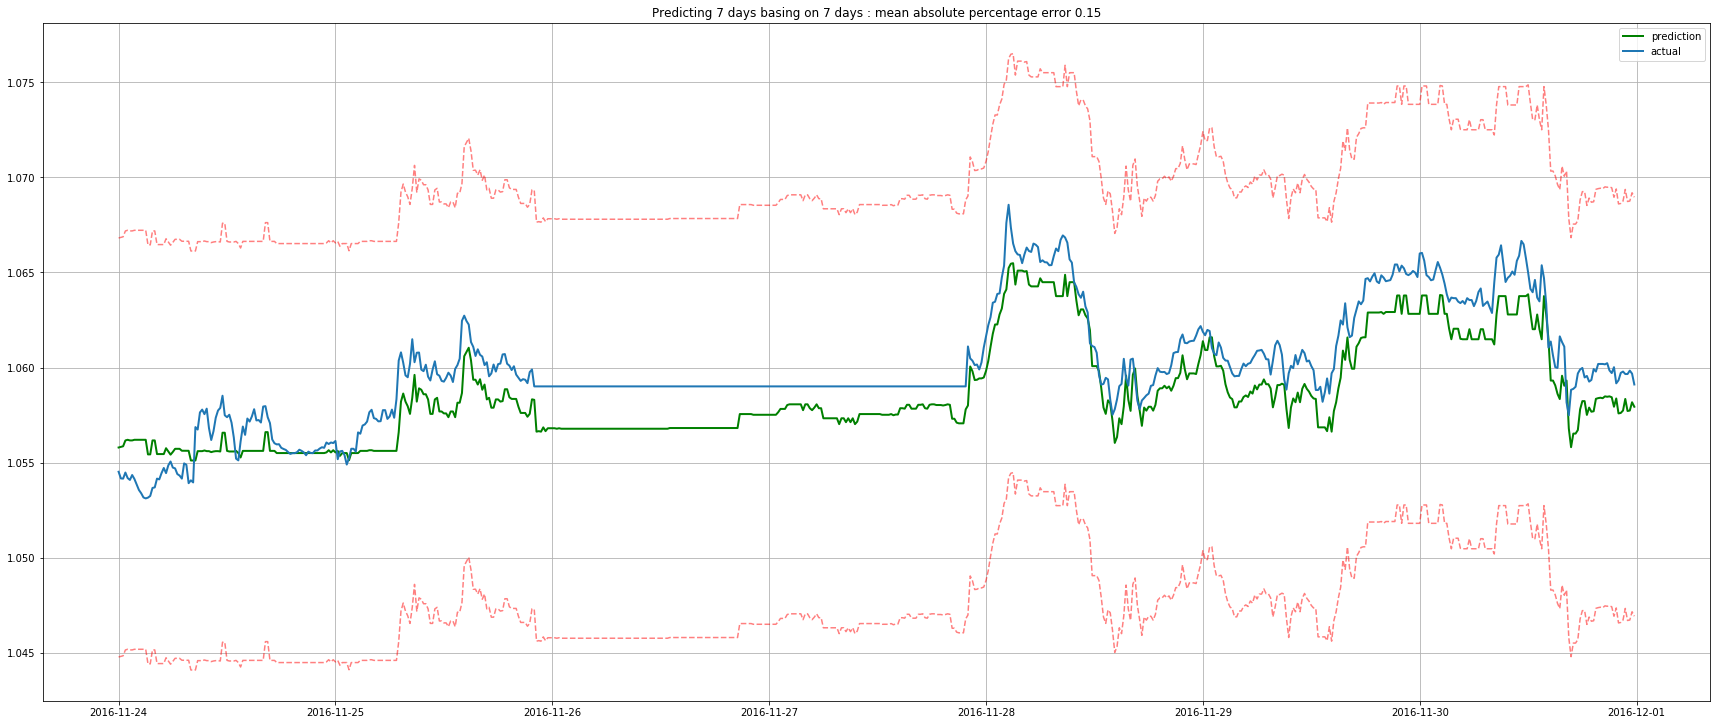

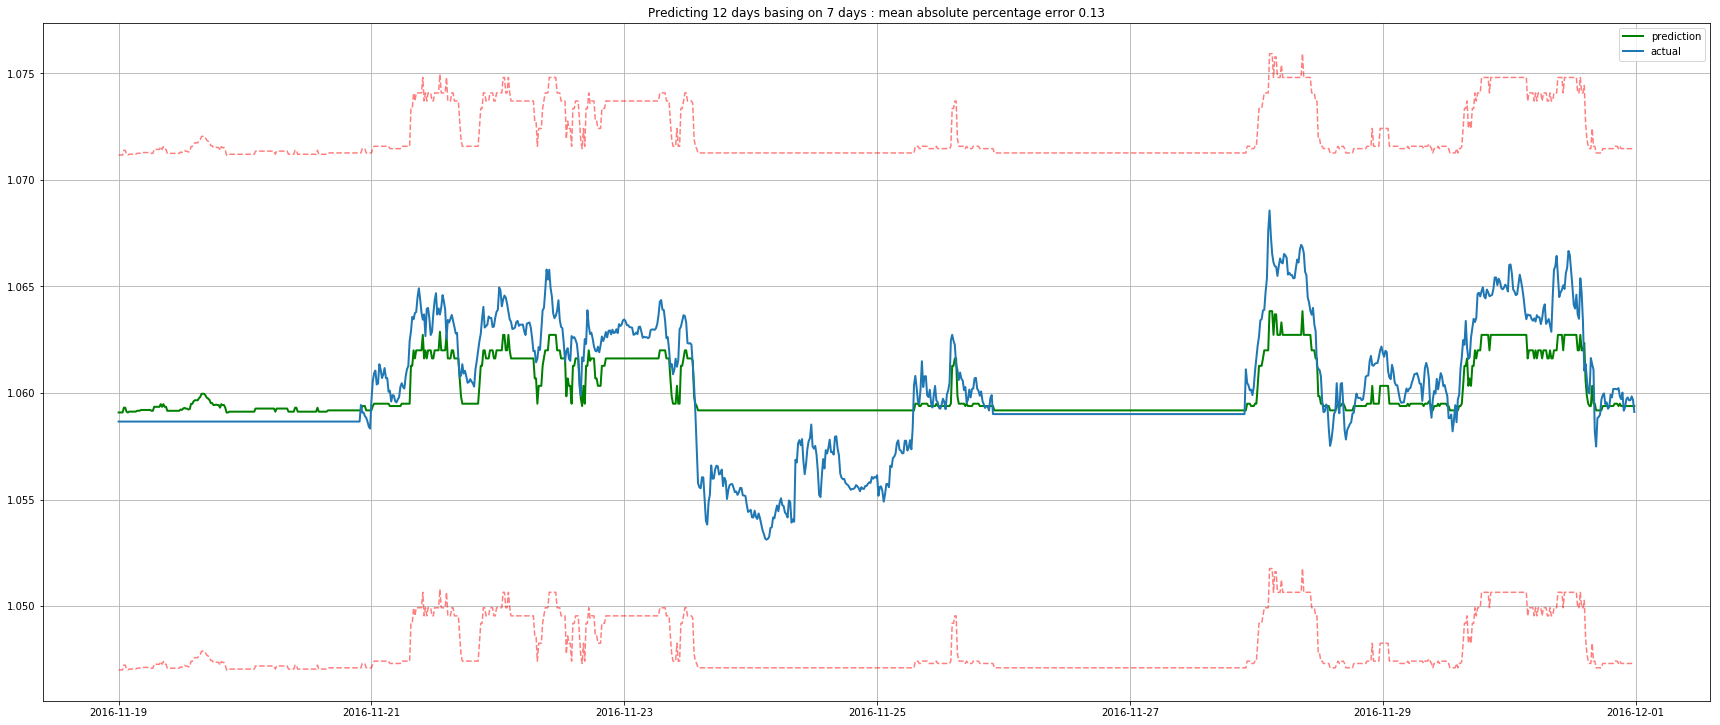

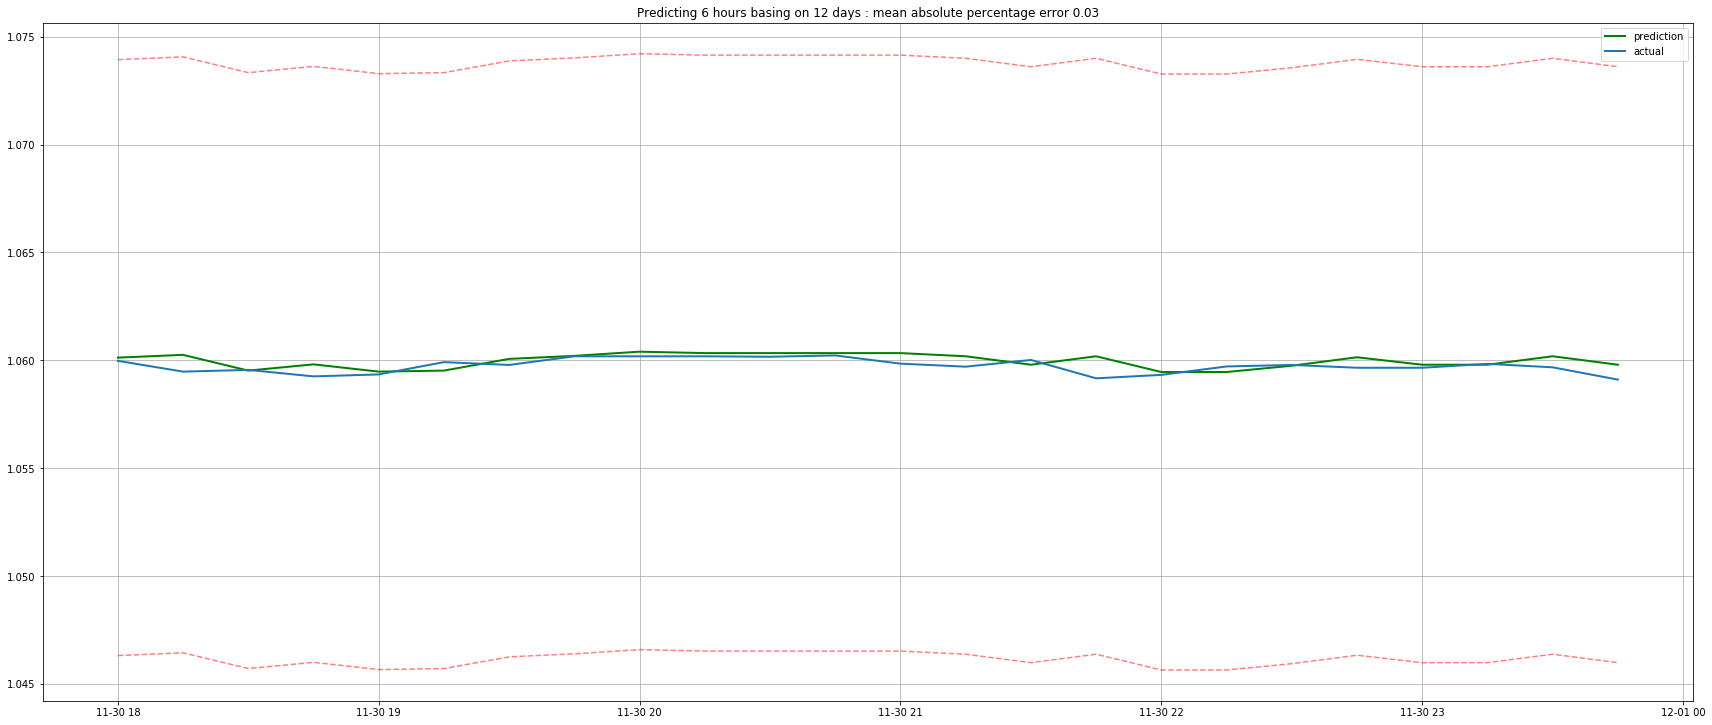

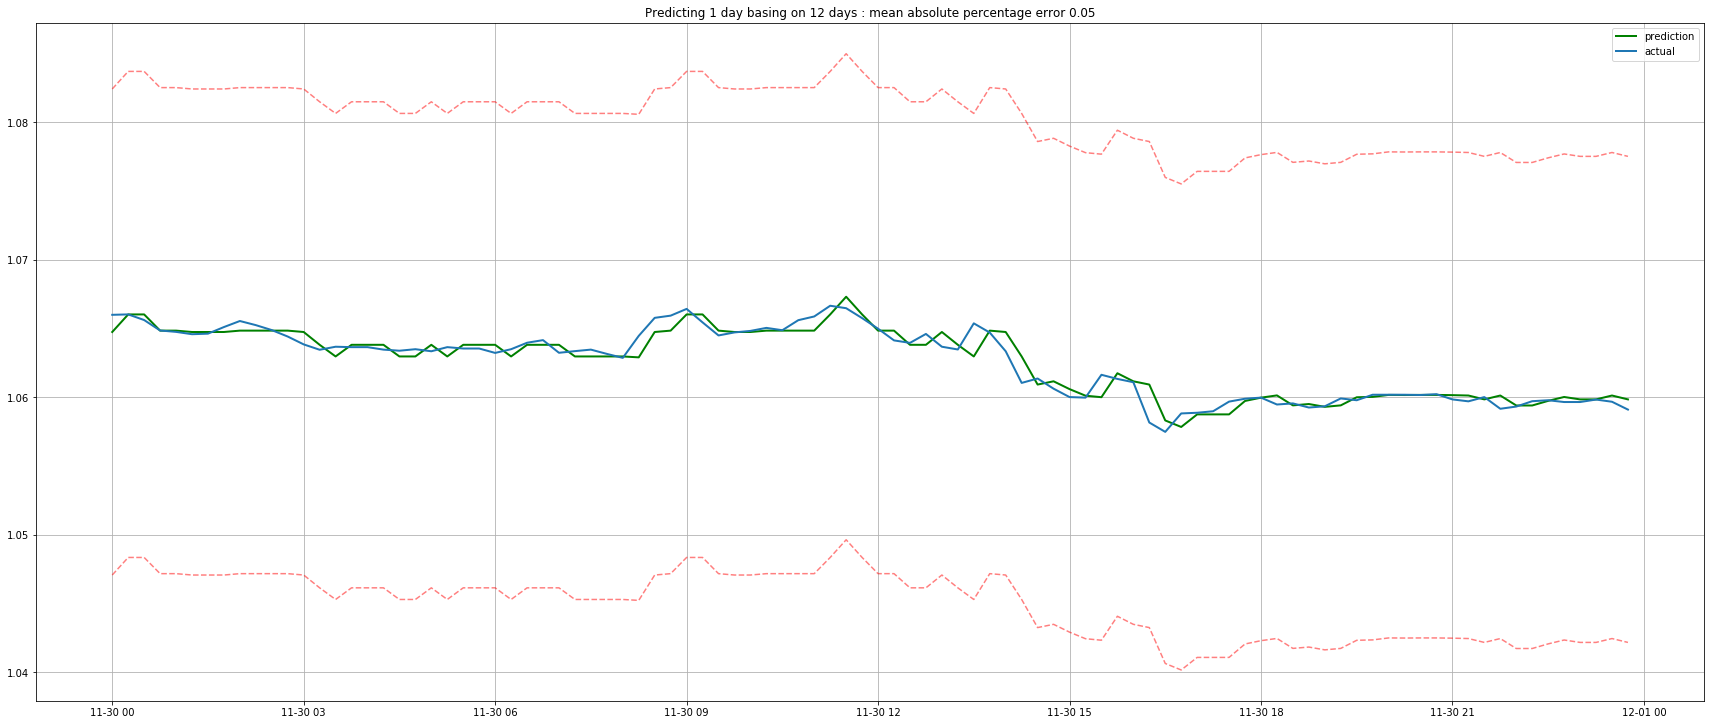

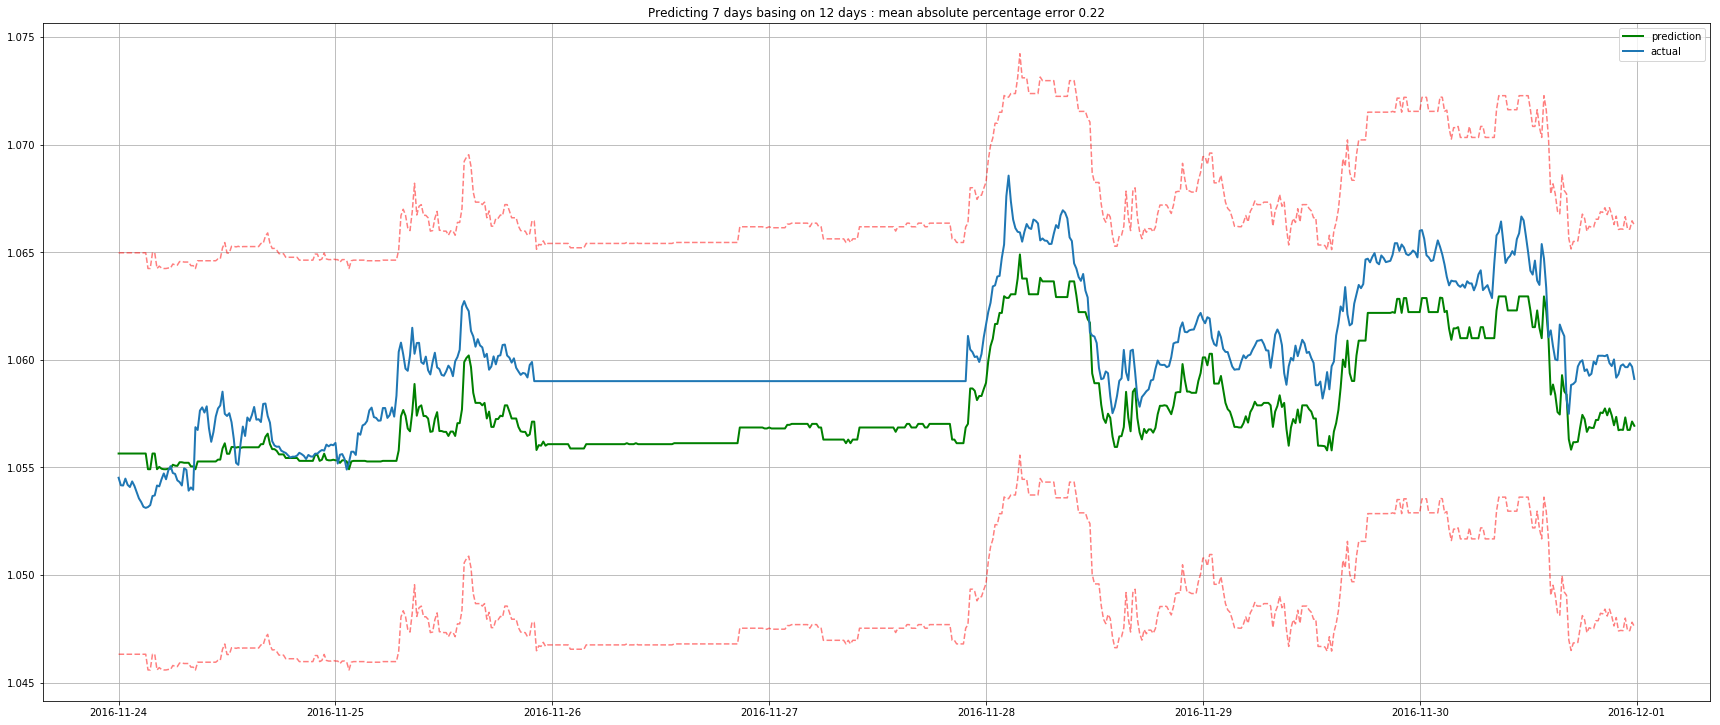

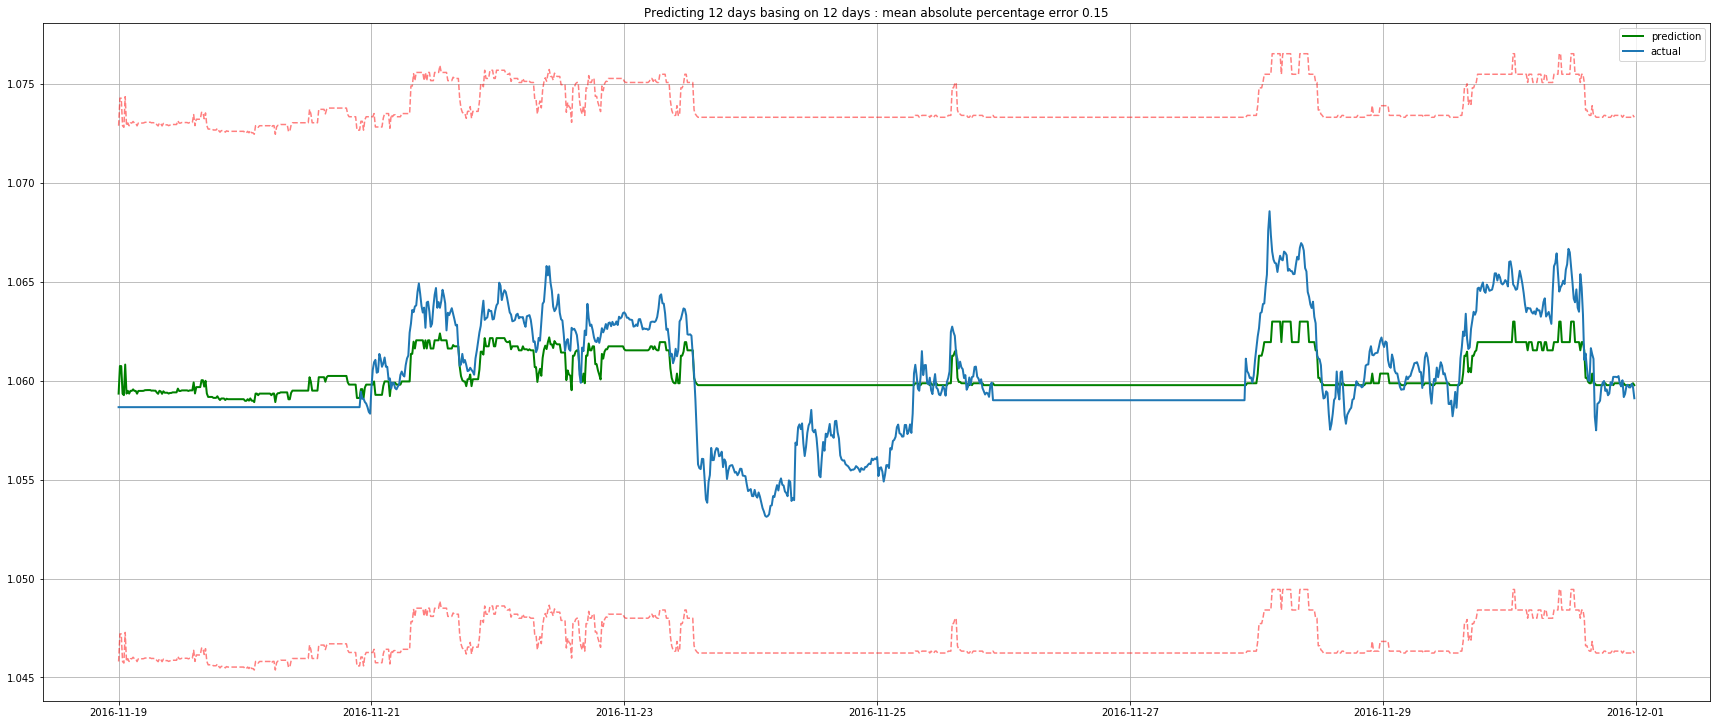

In [19]:
for series, obs_back, obs_to_predict, title, filename in runs:
    process_data(series,
                 obs_back,
                 obs_to_predict,
                 plt_draw=True,
                 plt_title=title,
                 plt_filename=filename,
                 plt_intervals=True,
                 plt_anomalies=True)

In [20]:
results = np.array(
    [
        [process_data(data['2016-10-01':'2016-11-30'],
                      daysEURUSD(backTo),
                      daysEURUSD(upTo)) for backTo in [0.25, 0.5, 1, 2, 3, 4, 6, 8]
        ]
        for upTo in [0.25, 0.5, 1, 2, 3, 4, 6, 8]
    ])

24.0 24.0
48.0 24.0
96 24.0
192 24.0
288 24.0
384 24.0
576 24.0
768 24.0
24.0 48.0
48.0 48.0
96 48.0
192 48.0
288 48.0
384 48.0
576 48.0
768 48.0
24.0 96
48.0 96
96 96
192 96
288 96
384 96
576 96
768 96
24.0 192
48.0 192
96 192
192 192
288 192
384 192
576 192
768 192
24.0 288
48.0 288
96 288
192 288
288 288
384 288
576 288
768 288
24.0 384
48.0 384
96 384
192 384
288 384
384 384
576 384
768 384
24.0 576
48.0 576
96 576
192 576
288 576
384 576
576 576
768 576
24.0 768
48.0 768
96 768
192 768
288 768
384 768
576 768
768 768


In [23]:
results

array([[0.02943836, 0.02898856, 0.02864022, 0.0285626 , 0.02873483,
        0.02848305, 0.02530363, 0.03024613],
       [0.0478986 , 0.04915434, 0.0475814 , 0.04819854, 0.05013588,
        0.05017036, 0.04948247, 0.04896722],
       [0.04775444, 0.04483993, 0.04732733, 0.04947886, 0.04828709,
        0.04787022, 0.04623581, 0.04814623],
       [0.04731159, 0.04572976, 0.04695008, 0.04723591, 0.04776753,
        0.04721574, 0.04543524, 0.04509396],
       [0.05101055, 0.04712379, 0.04854079, 0.04534669, 0.04770369,
        0.05034586, 0.0533364 , 0.05748471],
       [0.03783987, 0.04095448, 0.03841715, 0.03834041, 0.0375617 ,
        0.04123828, 0.0416673 , 0.04729039],
       [0.04012407, 0.04105423, 0.04309056, 0.04329355, 0.04995681,
        0.04756335, 0.13253725, 0.12447928],
       [0.08677701, 0.09129844, 0.08788509, 0.08773234, 0.08638456,
        0.08595721, 0.08390198, 0.09106232]])

Text(0.5, 1.0, 'Skuteczność detekcji X dni do przodu mając Y dni danych historycznych')

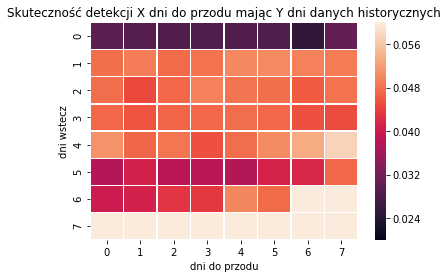

In [38]:
ax = sns.heatmap(results, linewidth=0.5, vmin=0.02, vmax=0.06)
plt.xlabel('dni do przodu')
plt.ylabel('dni wstecz')
plt.title('Skuteczność detekcji X dni do przodu mając Y dni danych historycznych')

In [53]:
def predict_up_to_given_back_to_get_error_value(series, observations_back, observations_to_predict):
    
    print(observations_back, observations_to_predict)
    
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test =\
        prepare_data(series, lag_start=1, lag_end=int(observations_back), test_count=int(observations_to_predict))

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    regressor = xgb.XGBRegressor()#gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.01)
    regressor.fit(X_train_scaled, y_train)
    y_predicted = regressor.predict(X_test_scaled)
    
    
    prediction = regressor.predict(X_test_scaled)
    error = mean_absolute_percentage_error(prediction, y_test)
    
    return error

In [56]:
errors = np.array(
    [
        [predict_up_to_given_back_to_get_error_value(data['2016-10':'2016-12'],
                      daysEURUSD(backTo),
                      daysEURUSD(upTo)) for backTo in [0.25, 0.5, 1, 2, 3, 4, 5, 6]
        ]
        for upTo in [0.25, 0.5, 1, 2, 3, 4, 5, 6]
    ])

24.0 24.0
48.0 24.0
96 24.0
192 24.0
288 24.0
384 24.0
480 24.0
576 24.0
24.0 48.0
48.0 48.0
96 48.0
192 48.0
288 48.0
384 48.0
480 48.0
576 48.0
24.0 96
48.0 96
96 96
192 96
288 96
384 96
480 96
576 96
24.0 192
48.0 192
96 192
192 192
288 192
384 192
480 192
576 192
24.0 288
48.0 288
96 288
192 288
288 288
384 288
480 288
576 288
24.0 384
48.0 384
96 384
192 384
288 384
384 384
480 384
576 384
24.0 480
48.0 480
96 480
192 480
288 480
384 480
480 480
576 480
24.0 576
48.0 576
96 576
192 576
288 576
384 576
480 576
576 576


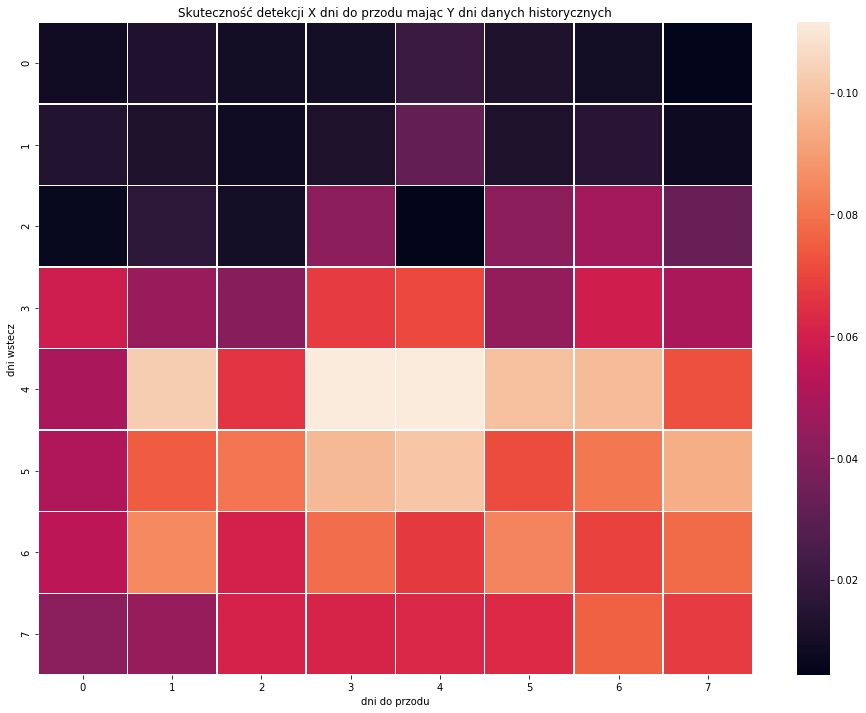

In [57]:
plt.figure(figsize=(16, 12))
ax = sns.heatmap(errors, linewidth=0.5)
plt.xlabel('dni do przodu')
plt.ylabel('dni wstecz')
plt.title('Skuteczność detekcji X dni do przodu mając Y dni danych historycznych')
plt.savefig('charts/heatmap_1.png')

In [42]:
errors2 = np.array([
    [
        predict_up_to_given_back_to_get_error_value(data['2016-10':'2016-12'], daysEURUSD(backTo), daysEURUSD(upTo))
        for backTo in range(1, 6)
    ] for upTo in range(1, 6)
])

96 96
192 96
288 96
384 96
480 96
96 192
192 192
288 192
384 192
480 192
96 288
192 288
288 288
384 288
480 288
96 384
192 384
288 384
384 384
480 384
96 480
192 480
288 480
384 480
480 480


In [45]:
errors2

array([[0.00999249, 0.04175272, 0.00439186, 0.04224478, 0.04798015],
       [0.04088806, 0.06788979, 0.07057149, 0.04406558, 0.05948394],
       [0.06608313, 0.11118932, 0.11149974, 0.0990886 , 0.0981716 ],
       [0.08020875, 0.09737668, 0.10102892, 0.07137616, 0.08097281],
       [0.06083855, 0.07862426, 0.06747739, 0.08426971, 0.06935713]])

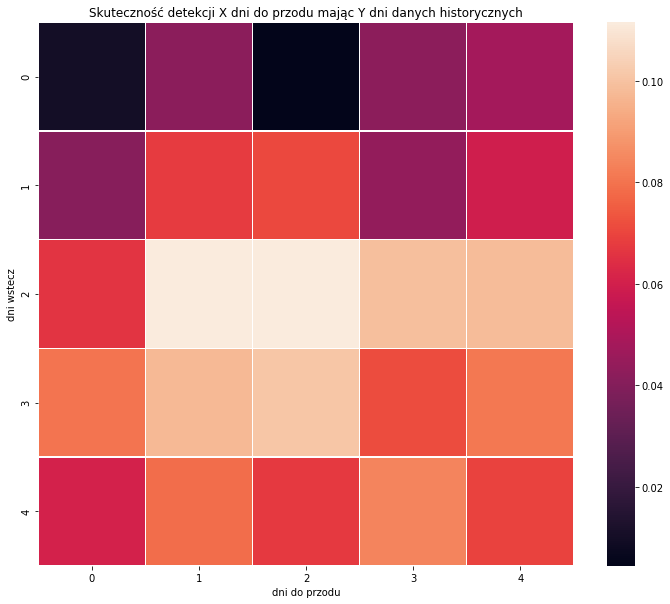

In [51]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(errors2, linewidth=0.5)
plt.xlabel('dni do przodu')
plt.ylabel('dni wstecz')
plt.title('Skuteczność detekcji X dni do przodu mając Y dni danych historycznych')
plt.savefig('charts/heatmap_2.png')

# DOM energy

In [59]:
data2 = pd.read_csv('./data/DOM_energy.csv', index_col='Time', parse_dates=['Time'])
data2.sort_index(inplace=True)

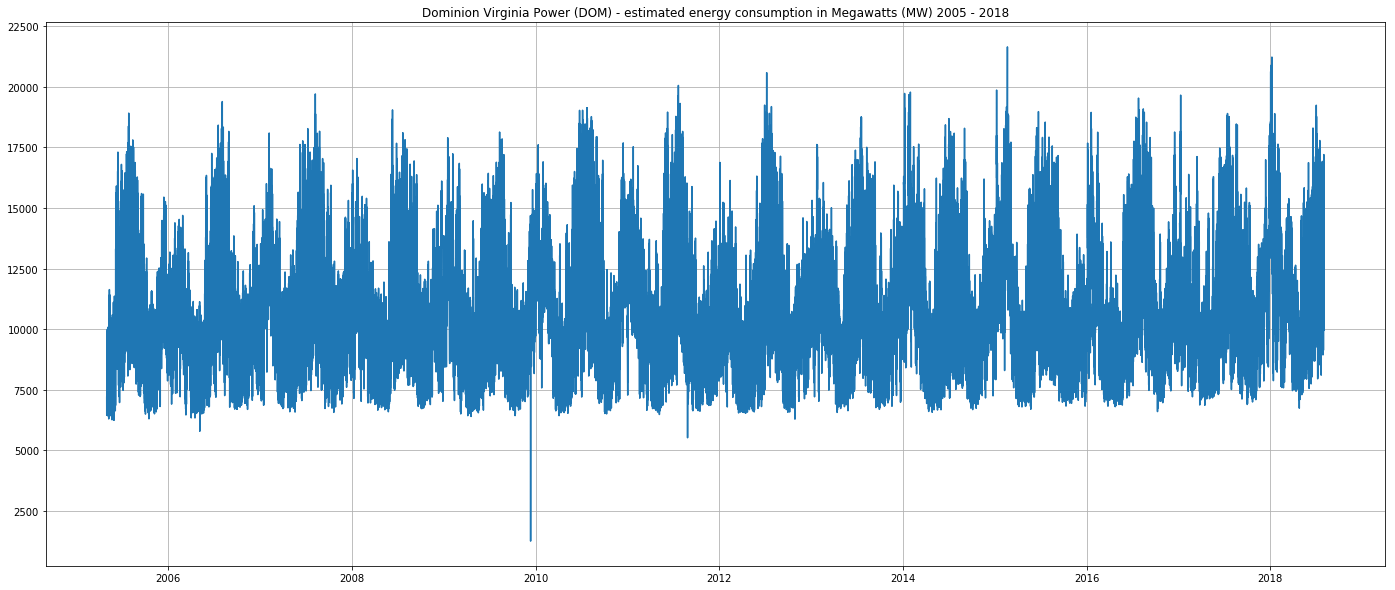

In [246]:
plot_raw_series(data2, 'Dominion Virginia Power (DOM) - estimated energy consumption in Megawatts (MW) 2005 - 2018', 'charts/DOM_energy_raw.png')


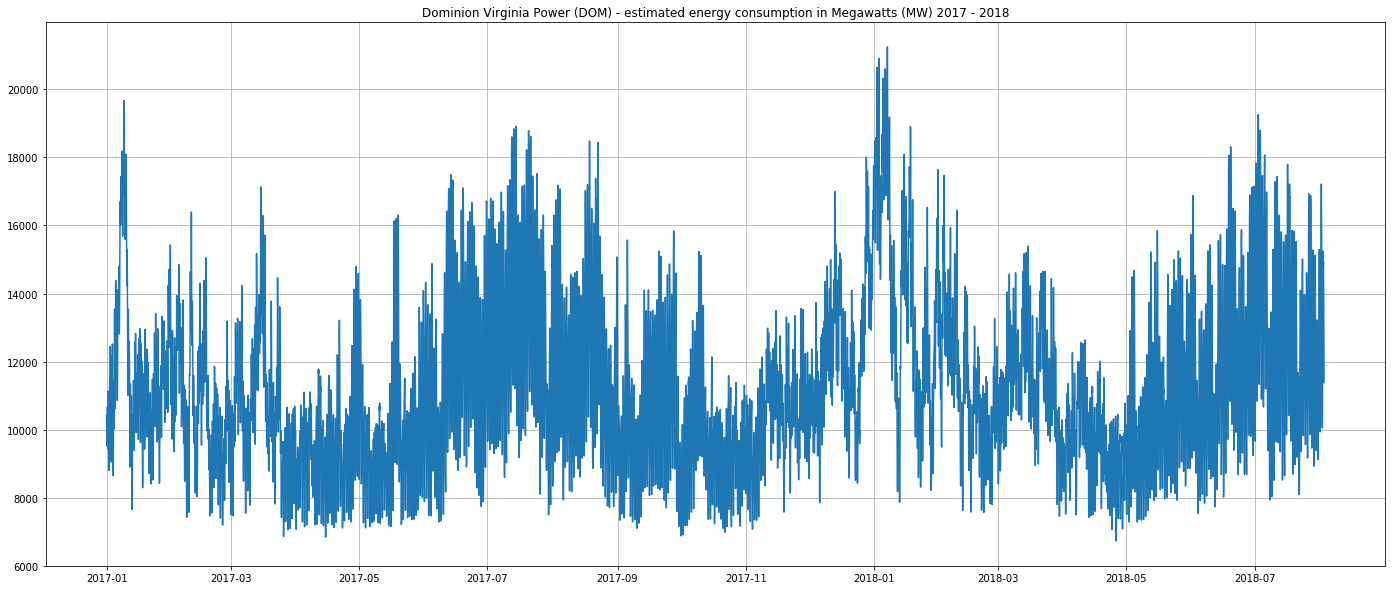

In [247]:
plot_raw_series(data2['2017':'2018'], 'Dominion Virginia Power (DOM) - estimated energy consumption in Megawatts (MW) 2017 - 2018', 'charts/DOM_energy_raw_17_18.png')

In [60]:
dataCountInDayDOM = 24
def daysDOM(count):
    return count * dataCountInDayDOM

In [66]:
process_data(
    data2['2017-10':'2017-12'],
    daysDOM(2),
    daysDOM(10),
    plt_draw=False,
    plt_title='Predicting 7 days basing on 1 day',
    plt_filename='charts/dom_1d_7d.png',
    plt_intervals=True,
    plt_anomalies=True,
)

48 240


3.142567910562625

In [61]:
runsDOM = [
    (data2['2017-10':'2017-12'], daysDOM(1), daysDOM(1), 'Predicting 1 day basing on 1 day', 'charts/dom_1d_1d.png'),
    (data2['2017-10':'2017-12'], daysDOM(1), daysDOM(2), 'Predicting 2 days basing on 1 day', 'charts/dom_1d_2d.png'),
    (data2['2017-10':'2017-12'], daysDOM(1), daysDOM(7), 'Predicting 7 days basing on 1 day', 'charts/dom_1d_7d.png'),

    (data2['2017-10':'2017-12'], daysDOM(2), daysDOM(1), 'Predicting 1 day basing on 2 days', 'charts/dom_2d_1d.png'),
    (data2['2017-10':'2017-12'], daysDOM(2), daysDOM(2), 'Predicting 2 days basing on 2 days', 'charts/dom_2d_2d.png'),
    (data2['2017-10':'2017-12'], daysDOM(2), daysDOM(7), 'Predicting 7 days basing on 2 days', 'charts/dom_2d_7d.png'),

    (data2['2017-10':'2017-12'], daysDOM(7), daysDOM(2), 'Predicting 2 days basing on 7 days', 'charts/dom_7d_2d.png'),
    (data2['2017-10':'2017-12'], daysDOM(7), daysDOM(7), 'Predicting 7 days basing on 7 days', 'charts/dom_7d_7d.png'),
    (data2['2017-10':'2017-12'], daysDOM(7), daysDOM(14), 'Predicting 14 days basing on 7 days', 'charts/dom_7d_14d.png'),

    (data2['2017-10':'2017-12'], daysDOM(14), daysDOM(7), 'Predicting 7 days basing on 14 days', 'charts/dom_14d_7d.png'),
    (data2['2017-10':'2017-12'], daysDOM(14), daysDOM(14), 'Predicting 14 days basing on 14 days', 'charts/dom_14d_14d.png'),
    (data2['2017-10':'2017-12'], daysDOM(14), daysDOM(21), 'Predicting 21 days basing on 14 days', 'charts/dom_14d_21d.png'),

    (data2['2017-10':'2017-12'], daysDOM(21), daysDOM(7), 'Predicting 7 days basing on 21 days', 'charts/dom_21d_7d.png'),
    (data2['2017-10':'2017-12'], daysDOM(21), daysDOM(14), 'Predicting 14 days basing on 21 days', 'charts/dom_21d_14d.png'),
    (data2['2017-10':'2017-12'], daysDOM(21), daysDOM(21), 'Predicting 21 days basing on 21 days', 'charts/dom_21d_21d.png'),
]

In [67]:
errorsDOM = np.array([
    [
        predict_up_to_given_back_to_get_error_value(data2['2017-10':'2017-12'], daysDOM(backTo), daysDOM(upTo))
        for backTo in range(1, 14)
    ] for upTo in range(1, 14)
])

24 24
48 24
72 24
96 24
120 24
144 24
168 24
192 24
216 24
240 24
264 24
288 24
312 24
24 48
48 48
72 48
96 48
120 48
144 48
168 48
192 48
216 48
240 48
264 48
288 48
312 48
24 72
48 72
72 72
96 72
120 72
144 72
168 72
192 72
216 72
240 72
264 72
288 72
312 72
24 96
48 96
72 96
96 96
120 96
144 96
168 96
192 96
216 96
240 96
264 96
288 96
312 96
24 120
48 120
72 120
96 120
120 120
144 120
168 120
192 120
216 120
240 120
264 120
288 120
312 120
24 144
48 144
72 144
96 144
120 144
144 144
168 144
192 144
216 144
240 144
264 144
288 144
312 144
24 168
48 168
72 168
96 168
120 168
144 168
168 168
192 168
216 168
240 168
264 168
288 168
312 168
24 192
48 192
72 192
96 192
120 192
144 192
168 192
192 192
216 192
240 192
264 192
288 192
312 192
24 216
48 216
72 216
96 216
120 216
144 216
168 216
192 216
216 216
240 216
264 216
288 216
312 216
24 240
48 240
72 240
96 240
120 240
144 240
168 240
192 240
216 240
240 240
264 240
288 240
312 240
24 264
48 264
72 264
96 264
120 264
144 264
168 264


In [68]:
errorsDOM

array([[1.5435981 , 2.16604421, 2.62656583, 3.73466867, 3.50087011,
        4.26450895, 3.54942332, 3.48283182, 2.68126017, 2.67597021,
        2.29638996, 2.7619445 , 3.42595213],
       [1.34776757, 1.29710671, 2.2889749 , 2.44100178, 2.57119518,
        2.43264383, 2.23620032, 2.4109348 , 2.21773515, 2.32754954,
        1.53524866, 1.86586264, 2.21250536],
       [1.7273351 , 1.70242114, 1.87593537, 1.74917281, 2.25658136,
        1.93902524, 2.13004578, 2.09131768, 1.85707668, 1.919482  ,
        1.7296307 , 2.11557501, 2.16730852],
       [5.66001867, 5.36475493, 5.36213636, 5.62475451, 5.29775093,
        5.68847081, 5.1734521 , 5.55868641, 5.5053593 , 5.59557243,
        5.32558737, 5.60336753, 5.10471908],
       [4.62424136, 5.4409353 , 5.39940638, 6.01317453, 5.58561014,
        5.42446479, 5.30247933, 5.57116362, 5.66714134, 5.65403074,
        5.55624995, 5.53120955, 5.62541646],
       [3.78805163, 4.43861321, 4.48329794, 5.27713804, 4.74427253,
        4.85453223, 4.81054

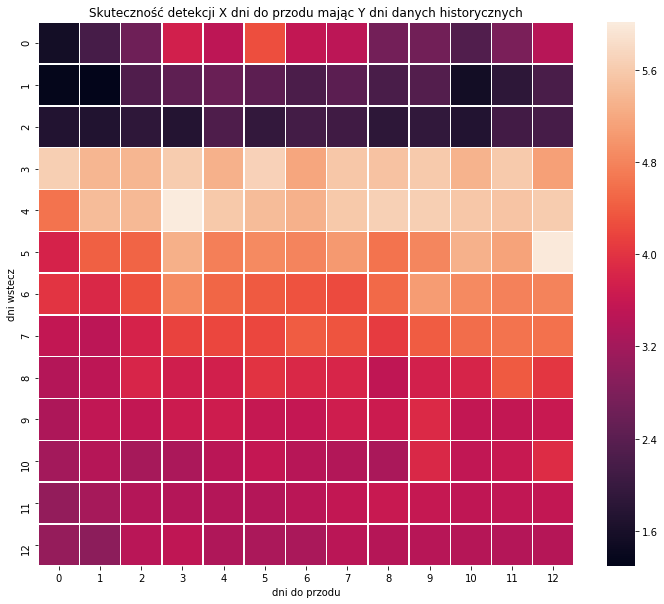

In [69]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(errorsDOM, linewidth=0.5)
plt.xlabel('dni do przodu')
plt.ylabel('dni wstecz')
plt.title('Skuteczność detekcji X dni do przodu mając Y dni danych historycznych')
plt.savefig('charts/heatmap_DOM.png')